### Initial setup

In [2]:
import os, sys
import getpass

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# setup Spark
import findspark # SPARK_HOME needs to be set for import of findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf

In [4]:
# add folder 'utils' to the Python path
# this folder contains custom written code that is required for data import and analysis
utils_dir = os.path.join(os.getcwd(), 'utils')
sys.path.append(utils_dir)

In [5]:
# OpenStack credentials (they override the values set in Hadoop's core-site.xml config)
os_username = 'hluetc'
os_tenant_name = 'helmchen.hifo.uzh'
# provide OS password
os_password = getpass.getpass()

········


In [6]:
# configuration for SC
conf = SparkConf()
master = 'local'
conf.setMaster(master)
# configure the max. number of cores a user may request
conf.set("spark.cores.max", 2)

In [7]:
# Initialize SC
try:
    sc = SparkContext(conf=conf)
except ValueError as exception:
    print "Could not create SparkContext. Maybe it exists already?"

In [8]:
# provide OS credentials to the Hadoop configuration
sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.username', os_username)
sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.tenant', os_tenant_name)
sc._jsc.hadoopConfiguration().set('fs.swift.service.SparkTest.password', os_password)

In [9]:
# add Python files in 'utils' folder to the SparkContext 
# this is required so that all files are available on all the cluster workers
for filename in os.listdir(utils_dir):
    if filename.endswith('.py'):
        sc.addPyFile(os.path.join(utils_dir, filename))

### Access and transfer files in Swift storage container

In [10]:
# test access to Swift (display contents of text file)
sc.textFile("swift://henry.SparkTest/textFile.txt").collect()

[u'test test test', u'file file file', u'', u'another line', u'']

In [11]:
# Specify HDF5 file stored in Swift and transfer it to all the workers for processing
swift_container = 'henry' # specify name of container in Swift (do not use _ etc.)
swift_provider = 'SparkTest' # in general, this should not change
swift_filename = 'Monyer_Leitner_F296_spot01.h5'

swift_path_to_file = "swift://" + swift_container + "." + swift_provider + "/" + swift_filename
print(swift_path_to_file)

swift://henry.SparkTest/Monyer_Leitner_F296_spot01.h5


In [13]:
# transfer the file from the Swift store to all the workers
sc.addFile(swift_path_to_file)
# get the location of the file on the workers
from pyspark import SparkFiles
path_to_file_workers = SparkFiles.get(swift_filename)
print(path_to_file_workers)

/private/var/folders/g5/yhphjv0d2sqc1zb8h2lz0vd80000gn/T/spark-4e3cd399-12d9-4aa1-80d9-f26337959ff9/userFiles-96cfddfe-4de3-4a06-b8a9-6ab8b9bbcd01/Monyer_Leitner_F296_spot01.h5


In [14]:
# Create RDD
from NeuroH5Utils import convert2RDD
numPartitions = 10 # how many partitions?
rdd = convert2RDD(sc, path_to_file_workers, numPartitions=numPartitions)

In [15]:
# Test RDD
nNeurons = rdd.count()
nNeurons

41

In [16]:
from NeuroH5Utils import getFileInfo
dsetSz, sampF, nTrials = getFileInfo(path_to_file_workers)

In [17]:
# Get time series from first roi to derive time axis and number of timepoints
s  = np.asarray(rdd.lookup(0))
t = (np.linspace(1, len(s[0]), len(s[0]))) / sampF 
nTimepoints = len(t)

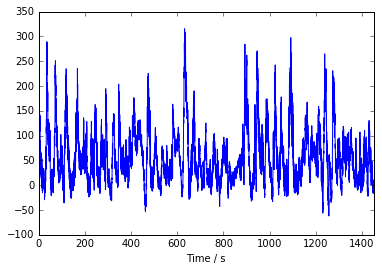

In [18]:
# Return a specific Roi as Python list / numpy array and plot the timeseries
roi = 0
s = rdd.lookup(roi) # returns a list
s = np.asarray(s) # convert to np array (actually not required for plotting)
plt.plot(t, s[0]);
plt.xlim((0, np.max(t)));
plt.xlabel('Time / s');

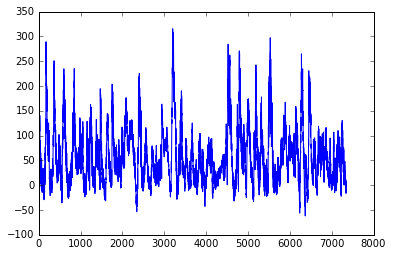

In [19]:
# Read the entire timeseries for one neuron (without Spark)
ix = 0 # Neuron index
from NeuroH5Utils import readPixel_map
x, result = readPixel_map(ix, path_to_file_workers, dim=1, debug=True) # debug=True will plot the data